In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [2]:

import cv2
import math

import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import size
from matplotlib import colors
from asgiref.sync import sync_to_async #in order to load variables to communicate between sync and async
import numpy.linalg as LA

import optimal_path as op
from robot import Robot
from Map import Map
from Local_navigation import* 
from Mouvement import*
from vision import*
from optimal_path import* 


map_lenght = 1
nb_of_square_by_side = 50
current = 0

global move 
old_distance = 0
old_angle = 0
ERR_POS = 3
speed_right = 0
speed_left = 0
thresh_indentation = 15 #nb of idx before the final path node for with we set the proxi off


#Enable variables:
move = False #bool which indicate how our robot is moving (1: avoid an object VS 0: following the optimal path)
kalman_bool = False
enable_blue_pos = False
enable_green_pos = True
enable_path_display = True
soon_arrived = False

In [3]:
VideoCap=cv2.VideoCapture(1)

In [4]:
@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500, verbose=False):
    """
    Sets the motor speeds of the Thymio 
    param l_speed: left motor speed
    param r_speed: right motor speed
    param verbose: whether to print status messages or not
    """
    global motor_left_target, motor_right_target
    # Printing the speeds if requested
    if verbose:
        print("\t\t Setting speed : ", l_speed, r_speed)
    motor_left_target = l_speed
    motor_right_target = r_speed

In [5]:
@tdmclient.notebook.sync_var
def proxi():
    """
    Returns the proximity values of the Thymio 
    """
    global prox_horizontal
    return prox_horizontal


In [7]:
#############################
#Test MASK  A LANCER QUE POUR FAIRE DES TESTS SUR LE MASK
#############################

while True:
    ret, frame = VideoCap.read()
    mask, b = mask_map_init(frame)
    
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        break
    cv2.imshow("mask",mask)
    cv2.imshow("mask B",b)
    #pos_robot, angle = update(frame, 0.5)


KeyboardInterrupt: 

In [6]:
#Objects initialisation:

George = Robot()
Lausanne = Map(map_lenght, nb_of_square_by_side)
KF = KalmanFilter(0.1,[0.0,0.0])
KF2 = KalmanFilter(0.1,[0.0,0.0])

taille frame (1080, 1920, 3)
MAP INITIALISATION
first while
searching for the strart pos
goal (28, 33)
start position (65, 8)
PATH COMPUTATION


True

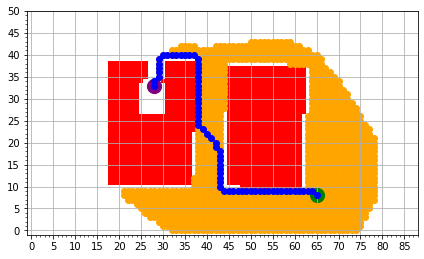

In [7]:
nb_frame_to_take = 10
for i in range (nb_frame_to_take): 
    ret, frame = VideoCap.read()
print("taille frame", frame.shape)

#uncomment to save the frame in jpg format
#cv2.imwrite("debut.jpg", frame)

print("MAP INITIALISATION")

# Set the pourcentage value between the nb of pixel and nb of square by side
Lausanne.set_map_lenght(frame)

# Set the robot goal, position and angle
goal = init_goal(frame, Lausanne.get_pourcentage())


print("   - first while")

#Use to be sure to have a correct start position to start the next computations
while (pos_robot[0] <= 0) & (pos_robot[1] <= 0):
    print("searching for the strart pos")
    
    ret, frame=VideoCap.read()
    pos_robot,pos_robot2, angle, bool_mesure = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....

#save values in the robot object
George.set_angle(angle)
George.set_goal(goal)
George.set_start_pos(pos_robot)
George.set_pos(pos_robot)
George.set_current(current)
print ("    --> goal", goal)
print ("    --> start position", pos_robot)

# SET MAP
print("   - Set the map parameters")
Lausanne.set_map_lenght(frame)
#print("Lausanna lenght", Lausanne.get_lenght())

# MASK 
print("   - Extract masks")
mask_bleu, mask_green = mask_map_init(frame)

#Uncomment to save the mask frame in jpg format:
#cv2.imwrite("masque1.jpg", mask_bleu)
#cv2.imwrite("masque2.jpg", mask_green)

# Fin de l'init
print("   - Grid initialisation")
Lausanne.init_grid(mask_bleu,mask_green)
grille = Lausanne.get_map()

#Uncomment to save the grid frame in jpg format:
#cv2.imwrite("grille.jpg", grille)

# OPTIMAL PATH
print("PATH COMPUTATION")
path, visitedNodes = op.path_computation(George.get_start() , George.get_goal() , Lausanne.get_lenght(), grille)

George.set_path(path) 
George.set_visit_nodes(visitedNodes) 

# Display the optimal path
op.display_map(Lausanne.get_lenght(),  grille,  George.get_visit_nodes(), George.get_path(), George.get_start(), George.get_goal())

# Display the path on the first frame.
display (frame, enable_blue_pos, enable_green_pos, enable_path_display, George.get_path(), Lausanne.get_pourcentage())

#Uncomment to save the final grid frame in jpg format:
#cv2.imwrite("TOTAL.jpg", frame)


In [8]:
print('START MOUVEMENT')
while True:
    # Read the camera
    ret, frame=VideoCap.read(1)
    
    # Get position and angle of the robot: 
    pos_robot, pos_robot2, angle_robot, bool_mesure = update(frame, Lausanne.get_pourcentage())
    
    # predict position and angle values of the robot
    pos = KF.kalmanFilter(bool_mesure, speed_left, speed_right, pos_robot, angle_robot)
    pos2 = KF2.kalmanFilter(bool_mesure, speed_left, speed_right, pos_robot2, angle_robot)
    x = pos2[0]-pos[0]
    y = pos2[1]-pos[1]
    angle_robot2 = KF.angle_of_vectors_2(x, y, 1, 0)
    
    #save the predicts values
    George.set_pos(pos)
    George.set_angle(angle_robot2)
    
    # Check if the robot is arrived
    if(current < George.get_path().shape[1]-1):
        current = path_update(pos, ERR_POS, np.transpose(George.get_path())[current], George.get_current())#
        George.set_current(current)
    else:
        print("READY TO PARK")
        motors(0,0)
        break
    
    # take the currrent goal
    pos_goal =  np.transpose(George.get_path())[current]
    
    #check if the robot is soon arrived
    if current > (George.get_path().shape[1] - thresh_indentation) :
        soon_arrived = True
        print('soon arrived')
    
    # Extract the proximity sensors
    proximity = proxi()
    
    
    #LOCAL NAVIGATION: check if there is an obstacle. If yes, avoid it.
    if move and not (soon_arrived):
        #Thymio is avoiding obstacles
        speed_l, speed_r, move = avoid_obstacle(prox_horizonta=proximity) 
    else:
        #Thymio is following the optimal path
        speed_l, speed_r, old_distance, old_goal  = move_to_position( pos, angle_robot2, pos_goal, old_distance, old_angle)#
        #Thymio is checking if there's an obstacle in front of it
        move = check_cars(prox_horizonta=proximity)
       
    # Save and set the speeds of the motors
    speed_right =  speed_r
    speed_left = speed_l
    motors(speed_l, speed_r) 
    
    # Display the map
    display (frame, enable_blue_pos, enable_green_pos, enable_path_display, path, Lausanne.get_pourcentage())
    
    # Quit when we press q
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        motors(0,0)
        break
     
    sleep(0.1)

print("PARK")


"""
proximity = proxi()

while proxis[2] > parking_treshold

    speed0 = 70
    err_angle = proxis[1]-proxis[3]
    err_dist = proxis[2]
    
    speed_l = speed0 + Kp*err_dist + Kp*err_angle
    speed _r = speed0 + Kp*err_dist - Kp*err_angle
    if(err_dist < min_err_dist)
        motors(0,0)
        print("ARRIVED")
        break
    motors(speed_l, speed_r)
    proximity = proxi()
    
"""
    

PATH [[65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 43
  43 43 43 43 43 43 43 42 42 41 40 39 38 38 38 38 38 38 38 38 38 38 38 38
  38 38 38 38 37 36 35 34 33 32 31 30 29 29 29 29 29 28 28]
 [ 8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 11
  12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
  36 37 38 39 40 40 40 40 40 40 40 40 39 38 37 36 35 34 33]]
START MOUVEMENT
pos avant kalman (65, 8)
Pos avant 2 (60, 8)
angle avant kalman 3.050932766389048
MESURE
MESURE
X 0.0
Y 0.0
pos après kalman (65, 8)
pos2 [0. 0.]
angle après kalman 0
0.1224610574173417
pos avant kalman (64, 8)
Pos avant 2 (60, 8)
angle avant kalman 3.0617626678775554
MESURE
MESURE
X -3.0
Y 0.0
pos après kalman (64, 8)
pos2 [40.  5.]
angle après kalman 3.141592653589793
-3.006064939604292
pos avant kalman (64, 8)
Pos avant 2 (60, 9)
angle avant kalman 2.9996955989856287
MESURE
MESURE
X -3.0
Y 0.0
pos après kalman (64, 8)
pos2 [52.6  7. ]
angle après kalman

pos avant kalman (58, 9)
Pos avant 2 (53, 9)
angle avant kalman 3.051834479399843
MESURE
MESURE
X -5.0
Y 0.0
pos après kalman (58, 9)
pos2 [52.8  9. ]
angle après kalman 3.141592653589793
0.0
pos avant kalman (57, 9)
Pos avant 2 (53, 9)
angle avant kalman 3.0309354324158977
MESURE
MESURE
X -5.0
Y 0.0
pos après kalman (57, 9)
pos2 [52.8  9. ]
angle après kalman 3.141592653589793
0.0
pos avant kalman (57, 9)
Pos avant 2 (53, 9)
angle avant kalman 3.0609597776446202
MESURE
MESURE
X -4.0
Y 0.0
pos après kalman (57, 9)
pos2 [52.8  9. ]
angle après kalman 3.141592653589793
next goal plz
0.0
pos avant kalman (57, 9)
Pos avant 2 (52, 9)
angle avant kalman 3.050932766389048
MESURE
MESURE
X -4.0
Y 0.0
pos après kalman (57, 9)
pos2 [52.8  9. ]
angle après kalman 3.141592653589793
0.0
pos avant kalman (57, 9)
Pos avant 2 (52, 9)
angle avant kalman 3.051834479399843
MESURE
MESURE
X -5.0
Y 0.0
pos après kalman (57, 9)
pos2 [51.8  9. ]
angle après kalman 3.141592653589793
0.0
pos avant kalman (56, 9)

pos avant kalman (44, 10)
Pos avant 2 (39, 11)
angle avant kalman 2.9764439761751667
MESURE
MESURE
X -3.0
Y 4.0
pos après kalman (44, 10)
pos2 [41. 14.]
angle après kalman 2.214297435588181
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (44, 10)
Pos avant 2 (39, 8)
angle avant kalman -2.852863125077396
MESURE
MESURE
X -4.0
Y 2.0
pos après kalman (44, 10)
pos2 [40. 12.]
angle après kalman 2.677945044588987
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (44, 10)
Pos avant 2 (39, 8)
angle avant kalman -2.8257944098477425
MESURE
MESURE
X -5.0
Y 0.0
pos après kalman (44, 10)
pos2 [38.9 10. ]
angle après kalman 3.141592653589793
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (44, 10)
Pos avant 2 (39, 8)
angle avant kalman -2.80800833209
MESURE
MESURE
X -5.0
Y -1.0
pos après kalman (44, 10)
pos2 [38.9  9. ]
angle après kalman -2.9441970937399127
OBSTACLLLEEEE
dans la boucle 1
dans la boucl

pos avant kalman (37, 7)
Pos avant 2 (32, 5)
angle avant kalman -2.834766364183236
MESURE
MESURE
X -4.0
Y -2.0
pos après kalman (37, 7)
pos2 [32.9  5. ]
angle après kalman -2.677945044588987
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (37, 7)
Pos avant 2 (32, 5)
angle avant kalman -2.834766364183236
MESURE
MESURE
X -5.0
Y -2.0
pos après kalman (37, 7)
pos2 [31.9  5. ]
angle après kalman -2.7610862764774287
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (37, 7)
Pos avant 2 (32, 5)
angle avant kalman -2.834766364183236
MESURE
MESURE
X -5.0
Y -2.0
pos après kalman (37, 7)
pos2 [31.9  5. ]
angle après kalman -2.7610862764774287
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (36, 6)
Pos avant 2 (32, 5)
angle avant kalman -2.837591714249649
MESURE
MESURE
X -5.0
Y -2.0
pos après kalman (36, 6)
pos2 [31.9  5. ]
angle après kalman -2.7610862764774287
OBSTACLLLEEEE
dans la boucle 1
dans la

pos avant kalman (31, 4)
Pos avant 2 (29, 9)
angle avant kalman 1.9880637188671815
MESURE
MESURE
X -4.0
Y 2.0
pos après kalman (31, 4)
pos2 [26.3  5.7]
angle après kalman 2.677945044588987
-1.996518433116197
pos avant kalman (31, 4)
Pos avant 2 (32, 9)
angle avant kalman 1.4302202753853388
MESURE
MESURE
X -3.0
Y 4.0
pos après kalman (31, 4)
pos2 [28.1  7.7]
angle après kalman 2.214297435588181
-1.5008469417541144
pos avant kalman (32, 4)
Pos avant 2 (34, 8)
angle avant kalman 1.0516502125483738
MESURE
MESURE
X 0.0
Y 5.000000000000001
pos après kalman (32, 4)
pos2 [31.   8.8]
angle après kalman 1.5707963267948966
-0.8663022625526788
pos avant kalman (32, 4)
Pos avant 2 (35, 7)
angle avant kalman 0.8288490587889792
MESURE
MESURE
X 1.0
Y 4.0
pos après kalman (32, 4)
pos2 [33.  8.]
angle après kalman 1.3258176636680323
-0.5880026035475674
pos avant kalman (32, 4)
Pos avant 2 (36, 7)
angle avant kalman 0.6129350918706182
MESURE
MESURE
X 2.0
Y 3.0
pos après kalman (32, 4)
pos2 [34.1  7.1]
an

pos avant kalman (41, 13)
Pos avant 2 (44, 17)
angle avant kalman 0.9932372077828825
MESURE
MESURE
X 3.0
Y 4.0
pos après kalman (41, 13)
pos2 [44.1 17.2]
angle après kalman 0.9272952180016123
0.17985349979247856
pos avant kalman (41, 13)
Pos avant 2 (44, 18)
angle avant kalman 1.0516502125483735
MESURE
MESURE
X 3.0
Y 4.0
pos après kalman (41, 13)
pos2 [44.1 17.2]
angle après kalman 0.9272952180016123
0.17985349979247856
pos avant kalman (41, 14)
Pos avant 2 (44, 18)
angle avant kalman 1.0902726829471692
MESURE
MESURE
X 3.0
Y 5.0
pos après kalman (41, 14)
pos2 [44.1 18.2]
angle après kalman 1.0303768265243125
0.07677189126977835
pos avant kalman (42, 14)
Pos avant 2 (44, 18)
angle avant kalman 1.1239538583091324
MESURE
MESURE
X 3.0
Y 4.0
pos après kalman (42, 14)
pos2 [44.1 18.2]
angle après kalman 0.9272952180016123
next goal plz
0.17985349979247856
pos avant kalman (42, 14)
Pos avant 2 (44, 19)
angle avant kalman 1.1364290501398686
MESURE
MESURE
X 2.0
Y 4.0
pos après kalman (42, 14)
p

pos avant kalman (43, 18)
Pos avant 2 (47, 19)
angle avant kalman 0.2355449807208633
MESURE
MESURE
X 4.0
Y 1.0
pos après kalman (43, 18)
pos2 [47. 19.]
angle après kalman 0.24497866312686423
OBSTACLLLEEEE
pos avant kalman (43, 18)
Pos avant 2 (47, 19)
angle avant kalman 0.22178096902259967
MESURE
MESURE
X 4.0
Y 1.0
pos après kalman (43, 18)
pos2 [47. 19.]
angle après kalman 0.24497866312686423
OBSTACLLLEEEE
pos avant kalman (42, 18)
Pos avant 2 (47, 20)
angle avant kalman 0.413480532146667
MESURE
MESURE
X 4.0
Y 1.0
pos après kalman (42, 18)
pos2 [47. 19.]
angle après kalman 0.24497866312686423
OBSTACLLLEEEE
pos avant kalman (42, 18)
Pos avant 2 (46, 21)
angle avant kalman 0.6267429012110468
MESURE
MESURE
X 5.0
Y 2.0
pos après kalman (42, 18)
pos2 [47. 20.]
angle après kalman 0.3805063771123646
OBSTACLLLEEEE
dans la boucle 1
pos avant kalman (42, 18)
Pos avant 2 (46, 21)
angle avant kalman 0.7266423406817257
MESURE
MESURE
X 4.0
Y 3.0
pos après kalman (42, 18)
pos2 [46. 21.]
angle après 

pos avant kalman (42, 18)
Pos avant 2 (40, 24)
angle avant kalman 1.8976229797248374
MESURE
MESURE
X -3.0
Y 5.0
pos après kalman (42, 18)
pos2 [39. 23.]
angle après kalman 2.1112158270654806
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
pos avant kalman (42, 19)
Pos avant 2 (40, 24)
angle avant kalman 1.955753713088999
MESURE
MESURE
X -2.0
Y 6.0
pos après kalman (42, 19)
pos2 [40.  24.1]
angle après kalman 1.8925468811915387
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
pos avant kalman (42, 19)
Pos avant 2 (38, 23)
angle avant kalman 2.2582430655495678
MESURE
MESURE
X -2.0
Y 5.0
pos après kalman (42, 19)
pos2 [40. 24.]
angle après kalman 1.9513027039072615
OBSTACLLLEEEE
dans la boucle 1
pos avant kalman (42, 19)
Pos avant 2 (37, 22)
angle avant kalman 2.551352917309015
MESURE
MESURE
X -3.0
Y 4.0
pos après kalman (42, 19)
pos2 [39. 23.]
angle après kalman 2.214297435588181
OBSTACLLLEEEE
dans la boucle 1
pos avant kalman (42, 19)
Pos avant 2 (37, 22)
angle avant kalman 2.46293016284

pos avant kalman (41, 20)
Pos avant 2 (36, 16)
angle avant kalman -2.4996467534960036
MESURE
MESURE
X -5.0
Y -2.0
pos après kalman (41, 20)
pos2 [36. 18.]
angle après kalman -2.7610862764774287
OBSTACLLLEEEE
pos avant kalman (41, 20)
Pos avant 2 (42, 24)
angle avant kalman 1.3284631601418817
MESURE
MESURE
X -5.0
Y -3.0
pos après kalman (41, 20)
pos2 [36. 17.]
angle après kalman -2.601173153319209
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (41, 20)
Pos avant 2 (42, 24)
angle avant kalman 1.3909428270024182
MESURE
MESURE
X -1.0
Y 1.0
pos après kalman (41, 20)
pos2 [40. 21.]
angle après kalman 2.356194490192345
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (41, 19)
Pos avant 2 (42, 24)
angle avant kalman 1.2924966677897851
MESURE
MESURE
X 0.0
Y 3.0
pos après kalman (41, 19)
pos2 [41.  23.2]
angle après kalman 1.5707963267948966
next goal plz
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant

pos avant kalman (38, 12)
Pos avant 2 (35, 8)
angle avant kalman -2.1127956045822276
MESURE
MESURE
X -3.0
Y -4.0
pos après kalman (38, 12)
pos2 [34.9  7.9]
angle après kalman -2.214297435588181
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (37, 12)
Pos avant 2 (35, 7)
angle avant kalman -2.109615828430812
MESURE
MESURE
X -3.0
Y -4.0
pos après kalman (37, 12)
pos2 [34.9  7.9]
angle après kalman -2.214297435588181
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (37, 11)
Pos avant 2 (35, 7)
angle avant kalman -2.109615828430812
MESURE
MESURE
X -2.0
Y -5.0
pos après kalman (37, 11)
pos2 [34.9  6.9]
angle après kalman -1.9513027039072615
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (37, 11)
Pos avant 2 (34, 7)
angle avant kalman -2.109615828430812
MESURE
MESURE
X -2.0
Y -4.0
pos après kalman (37, 11)
pos2 [34.9  6.9]
angle après kalman -2.0344439357957027
OBSTACLLLEEEE
dans la boucle 1

pos avant kalman (37, 8)
Pos avant 2 (40, 12)
angle avant kalman 1.0054598660310134
MESURE
MESURE
X 3.0
Y 3.999999999999999
pos après kalman (37, 8)
pos2 [40.2 11.2]
angle après kalman 0.9272952180016121
0.5959180055163014
pos avant kalman (38, 8)
Pos avant 2 (40, 13)
angle avant kalman 1.1525719972156676
MESURE
MESURE
X 3.0
Y 4.0
pos après kalman (38, 8)
pos2 [40.1 12.2]
angle après kalman 0.9272952180016123
0.5866005715184492
pos avant kalman (38, 9)
Pos avant 2 (39, 14)
angle avant kalman 1.2490457723982544
MESURE
MESURE
X 2.0
Y 5.0
pos après kalman (38, 9)
pos2 [40.1 13.2]
angle après kalman 1.1902899496825317
0.38683540652856685
pos avant kalman (38, 9)
Pos avant 2 (38, 14)
angle avant kalman 1.3808080388761808
MESURE
MESURE
X 1.0
Y 5.0
pos après kalman (38, 9)
pos2 [39.1 14.2]
angle après kalman 1.3734007669450157
0.20415221378566617
pos avant kalman (38, 9)
Pos avant 2 (61, 23)
angle avant kalman 0.5157476566419044
MESURE
MESURE
X 0.0
Y 5.0
pos après kalman (38, 9)
pos2 [38.1 14

pos avant kalman (38, 16)
Pos avant 2 (55, 35)
angle avant kalman 0.8579976171279429
MESURE
MESURE
X 1.0
Y 5.0
pos après kalman (38, 16)
pos2 [39.  21.2]
angle après kalman 1.3734007669450157
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (38, 17)
Pos avant 2 (39, 22)
angle avant kalman 1.3415643935179014
MESURE
MESURE
X 11.0
Y 14.0
pos après kalman (38, 17)
pos2 [49.1 30.1]
angle après kalman 0.9048270894157868
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (38, 17)
Pos avant 2 (39, 19)
angle avant kalman 1.2187520124794793
MESURE
MESURE
X 5.0
Y 8.0
pos après kalman (38, 17)
pos2 [43.  25.2]
angle après kalman 1.0121970114513341
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (38, 17)
Pos avant 2 (51, 35)
angle avant kalman 0.9447498043013651
MESURE
MESURE
X 3.0
Y 4.0
pos après kalman (38, 17)
pos2 [41.1 21.1]
angle après kalman 0.9272952180016123
OBSTACLLLEEEE
dans la boucle 1
dans

pos avant kalman (39, 26)
Pos avant 2 (39, 30)
angle avant kalman 1.5405025668761214
MESURE
MESURE
X 4.0
Y 2.0
pos après kalman (39, 26)
pos2 [43.1 27.1]
angle après kalman 0.46364760900080615
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (38, 26)
Pos avant 2 (42, 27)
angle avant kalman 0.2721458905311871
MESURE
MESURE
X 2.0
Y 3.0
pos après kalman (38, 26)
pos2 [41.  29.2]
angle après kalman 0.982793723247329
next goal plz
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (38, 26)
Pos avant 2 (47, 31)
angle avant kalman 0.5179420209091119
MESURE
MESURE
X 4.0
Y 2.0
pos après kalman (38, 26)
pos2 [42.1 28. ]
angle après kalman 0.46364760900080615
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (38, 27)
Pos avant 2 (47, 31)
angle avant kalman 0.4788308239430237
MESURE
MESURE
X 7.0
Y 4.0
pos après kalman (38, 27)
pos2 [45.1 30.1]
angle après kalman 0.5191461142465228
OBSTACLLLEEEE
dans la 

pos avant kalman (39, 31)
Pos avant 2 (47, 21)
angle avant kalman -0.9189272124893197
MESURE
MESURE
X 4.0
Y -1.0
pos après kalman (39, 31)
pos2 [43.  30.1]
angle après kalman -0.24497866312686423
next goal plz
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (39, 32)
Pos avant 2 (47, 20)
angle avant kalman -0.9720124698289139
MESURE
MESURE
X 6.0
Y -7.0
pos après kalman (39, 32)
pos2 [45.1 23.9]
angle après kalman -0.8621700546672264
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (39, 32)
Pos avant 2 (40, 37)
angle avant kalman 1.284175084569444
MESURE
MESURE
X 7.0
Y -11.0
pos après kalman (39, 32)
pos2 [46.1 20.9]
angle après kalman -1.0040671092713904
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (39, 32)
Pos avant 2 (40, 37)
angle avant kalman 1.3208177053340742
MESURE
MESURE
X 3.0
Y -1.0
pos après kalman (39, 32)
pos2 [42.  31.1]
angle après kalman -0.3217505543966423
next goal pl

pos avant kalman (41, 41)
Pos avant 2 (43, 46)
angle avant kalman 1.2457884549282485
MESURE
MESURE
X 1.0
Y 4.0
pos après kalman (41, 41)
pos2 [42.  45.1]
angle après kalman 1.3258176636680323
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (41, 42)
Pos avant 2 (43, 46)
angle avant kalman 1.2229079355149013
MESURE
MESURE
X 2.0
Y 5.0
pos après kalman (41, 42)
pos2 [43.  46.1]
angle après kalman 1.1902899496825317
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (41, 42)
Pos avant 2 (43, 46)
angle avant kalman 1.2390793249920473
MESURE
MESURE
X 2.0
Y 4.0
pos après kalman (41, 42)
pos2 [43.1 46.1]
angle après kalman 1.1071487177940904
OBSTACLLLEEEE
dans la boucle 1
dans la boucle 2
dans la boucle 3
pos avant kalman (41, 42)
Pos avant 2 (43, 46)
angle avant kalman 1.2229079355149013
MESURE
MESURE
X 2.0
Y 4.0
pos après kalman (41, 42)
pos2 [43.1 46.1]
angle après kalman 1.1071487177940904
OBSTACLLLEEEE
dans la boucle 1
dans l

pos avant kalman (39, 44)
Pos avant 2 (38, 39)
angle avant kalman -1.785268025543136
MESURE
MESURE
X -2.0
Y -4.0
pos après kalman (39, 44)
pos2 [36.9 39.8]
angle après kalman -2.0344439357957027
6.283185307179586
pos avant kalman (39, 44)
Pos avant 2 (38, 39)
angle avant kalman -1.7644183196508418
MESURE
MESURE
X -1.0
Y -5.0
pos après kalman (39, 44)
pos2 [38.  38.8]
angle après kalman -1.7681918866447774
5.996102937992443
pos avant kalman (39, 43)
Pos avant 2 (38, 39)
angle avant kalman -1.7777885210147175
MESURE
MESURE
X -1.0
Y -5.0
pos après kalman (39, 43)
pos2 [38.  38.8]
angle après kalman -1.7681918866447774
5.996102937992443
pos avant kalman (39, 43)
Pos avant 2 (37, 38)
angle avant kalman -1.8613070477612705
MESURE
MESURE
X -1.0
Y -4.0
pos après kalman (39, 43)
pos2 [38.  38.8]
angle après kalman -1.8157749899217608
next goal plz
soon arrived
5.708296705909493
pos avant kalman (38, 42)
Pos avant 2 (36, 38)
angle avant kalman -1.9941070824986165
MESURE
MESURE
X -2.0
Y -5.0
pos 

pos avant kalman (30, 38)
Pos avant 2 (29, 33)
angle avant kalman -1.7226787841748477
MESURE
MESURE
X -1.0
Y -5.0
pos après kalman (30, 38)
pos2 [29.  32.8]
angle après kalman -1.7681918866447774
soon arrived
5.996102937992443
pos avant kalman (30, 38)
Pos avant 2 (29, 33)
angle avant kalman -1.7000713308430395
MESURE
MESURE
X -1.0
Y -5.0
pos après kalman (30, 38)
pos2 [29.  32.8]
angle après kalman -1.7681918866447774
soon arrived
5.996102937992443
pos avant kalman (30, 38)
Pos avant 2 (29, 33)
angle avant kalman -1.6914199953749993
MESURE
MESURE
X -1.0
Y -5.0
pos après kalman (30, 38)
pos2 [29.  32.8]
angle après kalman -1.7681918866447774
soon arrived
5.996102937992443
pos avant kalman (30, 37)
Pos avant 2 (30, 33)
angle avant kalman -1.6714649789527254
MESURE
MESURE
X -1.0
Y -5.0
pos après kalman (30, 37)
pos2 [29.  32.8]
angle après kalman -1.7681918866447774
soon arrived
5.996102937992443
pos avant kalman (30, 37)
Pos avant 2 (30, 33)
angle avant kalman -1.6623761769375822
MESURE

'\nproximity = proxi()\n\nwhile proxis[2] > parking_treshold\n\n    speed0 = 70\n    err_angle = proxis[1]-proxis[3]\n    err_dist = proxis[2]\n    \n    speed_l = speed0 + Kp*err_dist + Kp*err_angle\n    speed _r = speed0 + Kp*err_dist - Kp*err_angle\n    if(err_dist < min_err_dist)\n        motors(0,0)\n        print("ARRIVED")\n        break\n    motors(speed_l, speed_r)\n    proximity = proxi()\n    \n'

In [9]:
# Close the camera
vision_end(VideoCap)

In [9]:
motors(0,0)